In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from livelossplot.tf_keras import PlotLossesCallback
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split 

import pickle

import numpy as np
import pandas as pd
from datetime import datetime 
import multiprocessing
import re
from bs4 import BeautifulSoup as bs
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import matplotlib.pyplot as plt

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore") #, category=np.VisibleDeprecationWarning)

print(tf.__version__)

2.12.0


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# data = pd.read_csv('../datasets/spam.csv', encoding="cp1251", usecols=['v1', 'v2'])
# data.head()   

In [4]:
#READ DATA
# def read_train_data():
#     data = pd.read_csv('../datasets/spam.csv', encoding="cp1251", usecols=['v1', 'v2'])
#     mapping = {'ham': 0, 'spam': 1}
#     data.replace({'v1': mapping}, inplace=True)
#     data.rename(columns={"v1": "labels"}, inplace=True)
#     data.rename(columns={"v2": "raw_text"}, inplace=True)
# #     data.drop(['violation'], axis=1, inplace=True)
#     print('Data size %d' % len(data))
#     print('Data headers %s' % data.columns.values)
#     return data

In [5]:
# data = read_train_data()

In [6]:
# data.head()

In [7]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(neurons, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.5)
        self.dropout2 = Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [8]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Preprocessing function

In [9]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022', 'hd'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [10]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [11]:
df_tra = pd.read_csv('../datasets/current_train_data.csv')
df_tra.head()

,time_spent_ms,raw_text,labels
0,100.0,"BIG LOADS, BRUNETTE, BIG DICKS, CUMSHOTS, PORN...",0
1,100.0,Crushed By Asian Ass MP4.mp4,0
2,100.0,Karol Arrives home and meet's Thatty on the so...,0
3,200.0,Karol Arrives home and meet's Thatty on the so...,0
4,100.0,Robbers Revenge WMV.wmv,0


In [12]:
# df = df_val[['text', 'labels']]

In [13]:
# df.head()

In [14]:
# df.labels.plot(kind='hist')

In [15]:
df_tra['text'] = df_tra.apply(lambda row: clean_text(row.raw_text), axis=1)

In [16]:
counter = counter_word(df_tra.text)  

In [79]:
counter['sex']

75

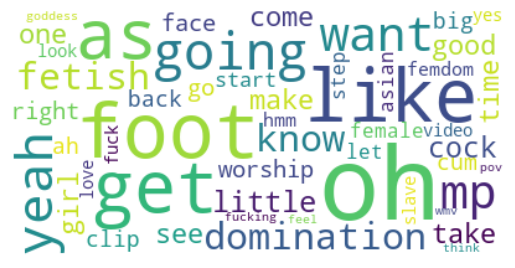

In [18]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [19]:
word_index =  dict()
for word, number in counter.items():
    word_index[word] = number + 3
    
word_index["<UNKNOWN>"] = 0
word_index["<FILLER>"] = 1
word_index["<BEGINOFSEQUENCE>"] = 2
word_index["<UNUSED>"] = 3

In [20]:
vocab_size = len(word_index)
oov_token = [k for k, v in word_index.items() if v == 0][0]
maxlen = 200

In [21]:
vocab_size

51181

In [22]:
from sklearn.utils import shuffle
RANDOM_STATE = 42

# df = shuffle(df, random_state=RANDOM_STATE).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(df_tra.text.values, df_tra.labels.values, 
                                                  stratify=df_tra.labels.values, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=0.2, shuffle=True)

In [23]:
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")

96790 Training sequences
24198 Validation sequences


In [24]:
y_val[:5]

array([1, 0, 0, 0, 1])

In [80]:
# vectorize a text corpus by turning each text into sentence of integers

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_tra.text.values)

# # saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('../models/tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [81]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=maxlen)
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_sequences, maxlen=maxlen)

# Build Model

In [82]:
embed_dim = 50  # 50 Embedding size for each token 32
num_heads = 7  # Number of attention heads default value 2
neurons = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, num_heads, neurons)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x) # .35
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 50)          2569050   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_1 (Tran  (None, 200, 50)          74582     
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 50)                0   

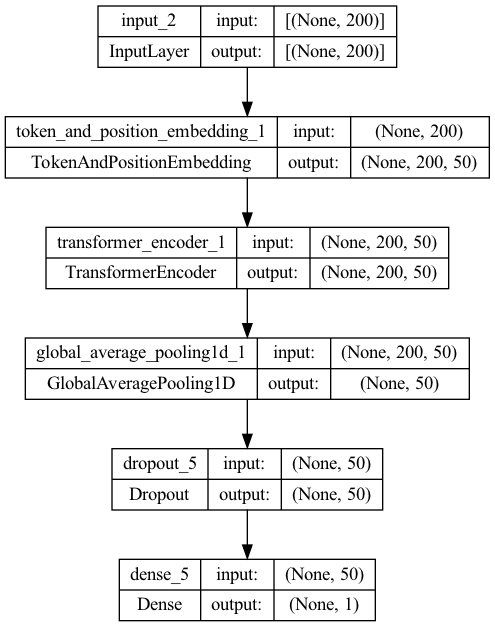

In [83]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

In [84]:
lr = 1e-5
epochs = 25

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=lr) #.000001)
metrics = ['accuracy']

# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]

# from pathlib import Path

# path = Path('../models/bad_words/trans/')
# path.mkdir(exist_ok=True) 
# cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
# cpt_path = str(path / cpt_filename)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=2, 
#                                                 save_best_only=True, mode='min')

# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=32, validation_data=(X_val_padded, y_val), verbose=1, 
#            callbacks=[checkpoint, PlotLossesCallback()])
          
# # history = model.fit(X_train_padded, y_train, 
# #                     batch_size=64, epochs=10, 
# #                     validation_data=(X_val_padded, y_val)
#                    )

In [ ]:
model_name = "../models/trans/trans_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_val_padded,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])
model.summary()

Epoch 1/25
1632/3025 [===============>..............] - ETA: 4:52 - loss: 0.2030 - accuracy: 0.9213

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

In [ ]:
plt.plot(history_df.loss);

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y_pred = model.predict(X_val_padded)
fpr, tpr, _ = roc_curve(y_val,  y_pred)
auc = roc_auc_score(y_val, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [ ]:
y_pred = [1 if p > .5 else 0 for p in y_pred]

print(classification_report(y_val, y_pred))

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_val, y_pred),annot=True,fmt='.4g',cmap='viridis')

In [ ]:
results = model.evaluate(X_val_padded, y_val, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

In [ ]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

In [ ]:
df_sequences = tokenizer.texts_to_sequences(df_tra.text)
df_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(df_sequences, maxlen=maxlen)

predictions = model.predict(df_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

df_tra['predicted'] = predictions
df_tra = df_tra[['time_spent_ms', 'text', 'labels', 'predicted']]
df_tra.head()

In [ ]:
df_tra.to_csv('../datasets/acc_989_model.csv')

In [ ]:
def roc_auc(predictions, target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

In [ ]:
# model.save_weights("../models/trans/trans_badwords_weights.h5")
# model.load_weights("../models/trans/trans_badwords_weights.h5") # loading weights - model had created erlier

In [ ]:
# model.save('../models/trans/trans_badwords_model.h5')
# model = tf.keras.models.load_model("../models/trans/trans_badwords_model.h5")
# model.trainable = False # замораживаем базовую модель

In [ ]:
df_val = pd.read_csv('../datasets/bw/BadWordsService_ml_has.csv')

In [ ]:
df_val.drop('@timestamp', axis=1, inplace=True)
df_val['ctxt_.time_spent'] = df_val['ctxt_.time_spent'] * 1000 # convert seconds to milliseconds

In [ ]:
df_val.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df_val.rename(columns={"ctxt_.time_spent": "time_spent_ms"}, inplace=True)

In [ ]:
df_val.head()

In [ ]:
nan_values = df_val[df_val.isna().any(axis=1)]
print(len(nan_values))

In [ ]:
df_val['text'] = df_val.apply(lambda row: clean_text(row.raw_text), axis=1)

In [ ]:
df_val.drop('raw_text', axis=1, inplace=True)
df_val.head()

In [ ]:
######## new
import itertools as itt
chunksize = 200
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 200
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_val['text'])


values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(df_val.text):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [ ]:
# del(df_result)
df_result.head()

In [ ]:
df_val.head()

In [ ]:
df_united = df_val.merge(df_result, right_on='text', left_on='text')
df_united['time_delta'] = df_united.time_spent_ms - df_united.time_elapsed_ms
df_united = df_united[['text', 'time_spent_ms', 'time_elapsed_ms', 'time_delta', 'label']]
df_united.drop_duplicates(['text'], keep='last', ignore_index=True, inplace=True)

In [ ]:
df_united.head(20)

In [ ]:
df_united.to_csv('../datasets/trans_pred_999.csv', index=False)

In [ ]:
######## new
import itertools as itt
chunksize = 200
max_len = chunksize

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# tokenizer.fit_on_texts(df_tra['text'])

# raw_text = """audrina terrified large dragon enters room quickly tell dragon distress find thorn mouth moment remove thorn viciously attacked slowly consumed putting strong fight excellent vore clipsgts x com"""
raw_text = """start	end	text
0	5040	Oh, I love wearing dirty panties.
9280	13040	Oh, you're rubbing my panties and filling out what they are.
16800	21040	Oh, they smell good.
21040	27040	Oh, I love wearing dirty panties and filling out what they smell good.
27040	33040	Oh, I love wearing dirty panties and filling out what they smell good.
33040	39040	Oh, I love wearing dirty panties and filling out what they smell good.
43040	49040	You can't tell me that a woman's panties haven't turned you on before.
49040	53040	The dirty kind.
53040	57040	The kind that she's been playing with herself in.
57040	65040	The kind that she's been coming in them all over and all over.
65040	73040	Oh, oh, oh, oh.
73040	79040	I love calmed in panties more than anything.
79040	85040	Oh, I want to ride on my face.
85040	91040	I want to run my pussy in my pussy.
91040	99040	Oh, I want to come slow, gone down hard to dirty panties.
99040	113040	Oh, oh, I need my exercise work.
113040	118040	Oh, here.
118040	120040	Holy Pisces, what?
122040	123040	Oh, yeah.
130040	132040	I like the taste of my pussy.
137040	139040	Oh, oh, yeah.
139040	142040	Oh, oh, yeah.
145040	149040	Oh, my god, I want some dirty panties right on my face.
155040	162040	You know, if you were here right now, I'd be making you sniff them too.
162040	167040	Oh, rubbing my dirty panties all over your dick.
170040	174040	Be wrapping my dirty panties around your dick and then fucking it.
180040	182040	Oh, I'm being deadly serious.
182040	187040	My fetish with pennies.
193040	196040	It has been going on for such a long time.
196040	203040	Oh, oh, oh, oh.
205040	210040	And dirty panties taste good.
210040	215040	Oh, oh, oh, oh.
224040	226040	Oh, yeah.
226040	228040	Oh, look at that.
228040	235040	I want to make health with those pennies.
240040	244040	I thought it'd come all over me.
244040	247040	And my mouth fell.
247040	251040	And my face.
251040	253040	Oh.
253040	255040	Oh.
257040	260040	Oh, yeah.
260040	262040	Oh.
262040	264040	Oh.
264040	266040	Oh.
266040	268040	Oh.
268040	271040	Oh.
271040	274040	Look at it.
274040	278040	I'll let you throw a score at heart.
278040	283040	I'll let you throw a dirty panties score.
286040	288040	You got it.
288040	290040	All right.
290040	294040	On that face of mine.
300040	303040	Oh, yeah.
303040	305040	Oh.
305040	307040	Mm.
307040	310040	These dirty panties look around my face.
310040	312040	Don't you think?
312040	314040	Oh.
314040	317040	Oh, yeah.
317040	320040	Mm.
320040	323040	Oh.
323040	326040	Mm.
326040	329040	Oh.
329040	331040	Oh.
331040	333040	Oh.
333040	335040	Mm.
335040	338040	Oh, you're up that pussy.
338040	340040	Oh.
340040	342040	Oh, you're up that pussy.
342040	346040	What those funny panties are right on my face.
346040	348040	Mm.
348040	351040	Mm.
351040	354040	Mm.
354040	357040	Mm.
357040	360040	Oh, yeah.
360040	363040	Oh.
363040	365040	Oh.
365040	368040	Oh, yeah.
368040	371040	Oh, my God, that's so scary.
371040	374040	Mm.
374040	377040	Mm.
377040	380040	Mm.
380040	383040	Mm.
383040	386040	Mm.
386040	389040	Mm.
389040	392040	Mm.
392040	395040	Mm.
395040	398040	Mm.
398040	400040	Mm.
400040	403040	Oh, yeah.
403040	406040	Mm.
406040	410040	I love dirty panties on my face.
410040	413040	Mm.
413040	416040	Mm.
416040	419040	Mm.
419040	422040	Mm.
422040	425040	Mm.
425040	428040	Mm.
428040	431040	Mm.
431040	434040	Mm.
434040	438040	Mm.
438040	443040	Mm.
443040	447040	I love them.
447040	450040	I'm glad they taste so good.
450040	454040	Mm.
454040	457040	Mm.
457040	460040	Mm.
460040	462040	Mm.
462040	465040	I'm here.
465040	468040	I got out of this.
468040	472040	I love these to the gym.
472040	474040	Can you tell?
474040	477040	I gotta come all over my nose.
477040	481040	Oh.
481040	484040	Oh, yeah.
484040	486040	Mm.
486040	489040	Oh.
489040	492040	Lickery with a pussy's band.
492040	495040	Oh.
495040	498040	Mm.
498040	502040	Oh.
502040	506040	Oh, these smell good.
506040	510040	Oh, these smell so good.
510040	514040	I love them on my face.
514040	517040	Mm.
517040	521040	Oh, I want them on my face.
521040	525040	Oh, yeah.
525040	528040	Oh, yeah.
528040	531040	Oh, I want to say that.
531040	534040	Oh, yeah.
534040	538040	Oh, yeah.
538040	542040	Oh, I'm dirty panties on my face.
542040	545040	Mm.
545040	549040	Oh, I'm dirty panties on my face.
549040	552040	Oh.
552040	555040	Oh, yeah.
555040	558040	Oh.
558040	562040	Oh, God, that pussy is so wet right now.
562040	566040	You're gonna see how wet that pussy is.
566040	568040	Oh, yeah.
568040	570040	Mm.
570040	573040	Oh.
573040	576040	Look at this.
576040	581040	Can you show you just how wet it is?
581040	584040	Oh.
584040	587040	Oh.
587040	592040	Oh, those panties are wet.
592040	595040	Oh, yeah.
595040	598040	Oh, these panties are wet.
598040	601040	Oh, yeah.
601040	606040	Oh, there's seven panties dripping wet.
606040	609040	Oh, yeah.
609040	611040	Oh.
611040	613040	Mm.
613040	615040	Oh.
615040	618040	Oh, yeah.
618040	623040	Oh, make that pussy come and let's start a panties.
623040	625040	Oh, yeah.
625040	629040	Oh, make that pussy come.
629040	631040	Oh.
631040	634040	Oh, yeah.
634040	637040	Mm.
637040	640040	Oh.
640040	643040	Mm.
643040	648040	Ain't bloody on it.
648040	652040	I got crumbly from my nose.
652040	655040	Oh, I got a teaspoon.
655040	658040	Mm.
658040	661040	Too dirty panties to choose from.
661040	664040	Mm.
664040	667040	Oh.
667040	670040	Mm.
670040	672040	Oh.
672040	676040	Oh, I get it tastes good.
676040	679040	Mm.
679040	683040	Oh, it tastes really good.
683040	686040	Mm.
686040	688040	Oh.
688040	691040	You know what?
691040	694040	I need them boys on my face.
694040	696040	Oh, yeah.
696040	699040	Oh, I need them boys on my face.
699040	702040	Oh.
702040	704040	Oh, yeah.
704040	707040	Oh, they're right there.
707040	709040	Oh.
709040	711040	Oh, yeah.
711040	714040	Oh.
714040	719040	Oh, yeah.
719040	722040	Oh, yeah.
722040	725040	Mm.
725040	728040	Oh, yeah.
728040	731040	Oh, yeah.
731040	735040	Oh, yeah.
735040	739040	My pussy is so too my pussy, Jesus.
739040	742040	Mm.
742040	745040	Mm.
745040	748040	No.
748040	755040	I think they better take these ones off, right?
755040	758040	Mm.
758040	763040	And take these ones off.
763040	766040	Oh.
766040	769040	Oh.
769040	773040	Oh, what they are.
773040	776040	Mm.
776040	781040	And look at these.
781040	784040	Mm.
784040	788040	And look at me white pennies.
788040	791040	Mm.
791040	794040	Oh.
794040	797040	Mm.
797040	800040	Oh, yeah.
800040	804040	I can taste right what my pussy's meant.
804040	807040	Mm.
807040	810040	Oh.
810040	813040	Oh, yeah.
813040	816040	Mm.
816040	819040	Mm.
819040	822040	Mm.
822040	825040	Mm.
825040	829040	My panties taste good.
829040	832040	Mm.
832040	837040	My panties taste really good.
837040	840040	Oh.
840040	843040	Mm.
843040	846040	Oh.
846040	853040	Oh, I want to write on my face.
853040	856040	Oh, yeah.
856040	861040	Oh, you're right on my face.
861040	863040	Oh.
863040	866040	Oh, yeah.
866040	869040	I want to say that.
869040	871040	Mm.
871040	873040	Oh, yeah.
873040	875040	Oh.
875040	879040	Mm.
879040	883040	Oh, yeah.
883040	886040	Mm.
886040	889040	Mm.
889040	892040	Mm.
892040	895040	Mm.
895040	898040	Oh, yeah.
898040	902040	Mm.
902040	906040	Mm.
906040	909040	Oh.
909040	912040	Oh.
912040	915040	Mm.
915040	918040	Oh, yeah.
918040	921040	Mm.
921040	924040	Oh.
924040	927040	Oh.
927040	930040	Mm.
930040	932040	Oh.
932040	936040	Mm.
936040	940040	Mm.
940040	944040	Mm.
944040	949040	Mm.
949040	951040	Mm.
951040	954040	You know what I want?
954040	957040	Oh.
957040	961040	I want to wrap these dirty panties.
961040	964040	Oh.
964040	968040	I already know your dick. Look at my face.
968040	972040	My face is covered in corn.
972040	975040	Mm.
975040	978040	Oh.
978040	981040	Mm.
981040	983040	There we go.
983040	986040	No, that's what I really want.
986040	992040	You're going to need a cray just down.
992040	995040	Leave your head.
995040	1004040	Oh.
1004040	1007040	Let's get those panties.
1007040	1011040	These dirty, dirty panties.
1011040	1013040	Mm.
1013040	1015040	Oh, look at it.
1015040	1019040	Mm.
1019040	1023040	Mm.
1023040	1026040	Oh.
1026040	1029040	You're right on that.
1029040	1032040	Oh.
1032040	1034040	Oh, yeah.
1034040	1036040	And this one.
1036040	1038040	A dirty part.
1038040	1040040	Mm.
1040040	1043040	Oh, yeah.
1043040	1046040	Oh.
1046040	1048040	Oh.
1048040	1051040	And then.
1051040	1054040	Oh, yeah.
1054040	1056040	These are going to go going wrong.
1056040	1058040	Oh.
1058040	1061040	I'll let face them in.
1061040	1062040	Mm.
1062040	1064040	Oh, okay.
1064040	1066040	Mm.
1066040	1067040	Oh.
1067040	1072040	I like ricking them.
1072040	1078040	I love ricking them.
1078040	1080040	Oh.
1080040	1083040	Oh, if I.
1083040	1086040	Oh.
1086040	1089040	Oh.
1089040	1094040	We want to ride inside.
1094040	1097040	Oh, I want to ride inside.
1097040	1100040	Oh, yeah.
1100040	1102040	Oh.
1102040	1103040	Mm.
1103040	1107040	You need to have to ride around the dick.
1107040	1110040	Oh.
1110040	1113040	Oh, yeah.
1113040	1116040	Oh.
1116040	1119040	Oh.
1119040	1122040	Oh, yeah.
1122040	1125040	Oh, yeah.
1125040	1134040	Oh, and dirty panties are right on my face.
1134040	1137040	Oh, yeah.
1137040	1140040	Mm.
1140040	1143040	Oh.
1143040	1146040	Oh, yeah.
1146040	1149040	Mm.
1149040	1153040	Oh, yeah.
1153040	1157040	Mm.
1157040	1160040	Mm.
1160040	1163040	Mm.
1163040	1165040	Mm.
1165040	1168040	Oh, yeah.
1168040	1171040	Oh.
1171040	1174040	Oh, yeah.
1174040	1177040	Oh, yeah.
1177040	1180040	Oh, yeah.
1180040	1183040	Oh, yeah.
1183040	1186040	Mm.
1186040	1189040	Mm.
1189040	1192040	Mm.
1192040	1207040	You know what I was really like right now?
1207040	1215040	It's for you to concentrate on my face and my head.
1215040	1225040	You know what I was really like right now?
1225040	1252040	You know what I was really like right now?
1252040	1262040	You know what I was really like right now?
1262040	1270040	You know what I was really like right now?
1270040	1295040	You know what I was really like right now?
1295040	1305040	How much do you want to come on my face right now?
1305040	1321040	How much do you want to come on my face?
1321040	1331040	Just like that.
1331040	1357040	You know what I was really like right now?
1357040	1369040	I come to life in my panties and I think you come to it too.
1369040	1379040	Daddy Pony is a heart rate and that's plenty more what it came from."""
# raw_text = """start end text getting started sweetheart going get information going think anything going torture going talk going talk say wait wait done sensitive love torturing torturing oh god sexy oh god much love teasing going get talk frankly enjoying every moment never work say torment pleasure going painful good feel take oh sticky going able resist torment oh yes much fun resist going resist oh feel shaking torment hard crazy oh god oh yes good love torturing feel good oh god sweet torture oh god think like torture torturing beautiful body bring height pleasure take able make anything able make tell anything want anything really get anything going get oh god oh god oh yes oh torture oh yes pure torture oh yes oh yes oh yes oh yes resist oh go slow torture oh god good know oh god oh yes oh yes oh yes oh mine play oh yes anything want anything yeah bring entire body life tantalizing teasing oh oh yes oh able resist hurting hard oh god much longer good oh let taste sweet oh bug god oh hard going tell still going tell oh okay get oh going torture love torturing take care take care take care take care oh yes oh god oh god terrible oh yes oh sorry oh yes pleasure oh fun torturing oh teasing oh yes taking right edge close oh god become going tell oh going tell oh close oh daytime oh god oh god fine teasing good love teasing torturing breathe know going come oh know know oh expert torture oh yeah oh mm hmm oh mm hmm oh god oh god glad going come want come wow always leave leave let come oh fine really torturing way please going come oh please think going oh yes since get information leaving torture tormenting okay talk tell want know coming okay coming coming coming coming oh fuck coming touch oh oh yeah like hmmm hmmm hmmm hmm uh uh uh uh hmmm going tell everything yeah yes oh oh oh oh broke torture mm hmm good yeah taste amazing love torturing torturing please okay mm hmm"""
# raw_text = """<br></br>  This is the 640x360     version of  Jazmine aka Hannah Perez back for more clip four  : Limp, naked and played with    <br></br>Hannah has no idea where she is and who the stranger in front of her is. Needless to say, she is confused and tries to find out what happened to her but before she knows what hits her, she feels the guys hand on her throat and... her sexy young body wobbles and she slowly goes down while her eyes roll and flicker to the last second.     <br></br>Enjoy a very hot limp/rest segment. Like I mentioned this clip is all about our sleeepy girl being slowly moved, posed, dropped and other wise manipulated while out. Of course we take our time (and zoom in) while checking  her pussy, ass,  eyes, ears, hands, navel, remove her shoes, feet and so much more. Eye checks of course as well.  <br></br>HAND AND WRIST LIMPING, SEVERAL HAND AND LEG DROPS, FACE, RAGDOLLING, BODY LIMPING, PULLS, HEAD DROP"""
test_text_preprocessed = [clean_text(raw_text)]
print(test_text_preprocessed)
values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(test_text_preprocessed):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)]) #max(predictions)
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
df_result

In [ ]:
# def decode(sequence):
#     return " ".join([rvi.get(idx, "?") for idx in sequence])

# decoded_text = decode(X_train_sequences[10])

# print(X_train_sequences[10])
# print(decoded_text)